# Model Dependency Analysis Using SHAP: Winger Model

The task here is to analyze partial dependency of the trained Winger model using SHAP(SHapley Additive exPlanations).

In [29]:
import joblib
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

shap.initjs()

# Load Data

In [30]:
# Load in our data
filepath = '../../Data/Warehouse/MergedData/ML_data.csv' 
data = pd.read_csv(filepath)

wingers = data[data['POSITION'].isin(['r', 'l', 'l, r'])].copy()

# Select only players with 41 or more games played
wingers_41GP = wingers[(wingers['GP'] >= 41)].copy()
test_train_data = wingers_41GP

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP', 'CF/GP'])

X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Load in the pipeline using joblib

pipeline = joblib.load('Winger_Model/winger_salary_pipeline.pkl')

In [32]:
# Make predictions (this part seems fine)
y_pred = pipeline.predict(X_test)

# get rfecv from pipeline
rfecv = pipeline.named_steps['selector']

# Now, for SHAP values, we need to ensure we only consider features that were kept after RFECV
# Extract the support mask from RFECV to identify selected features
selected_features = rfecv.get_support(indices=True)
selected_feature_names = [numerical_features[i] for i in selected_features]

# Apply transformation only on selected features
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)[:, selected_features]

# Now, create a DataFrame with correctly selected features for SHAP
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=selected_feature_names, index=X_test.index)

# Proceed with SHAP explainer
explainer = shap.Explainer(pipeline.named_steps['regressor'].get_booster())  # Ensure to get the underlying booster for SHAP
shap_values = explainer(X_test_transformed_df)  # This should now align with expected dimensions

<Figure size 640x480 with 0 Axes>

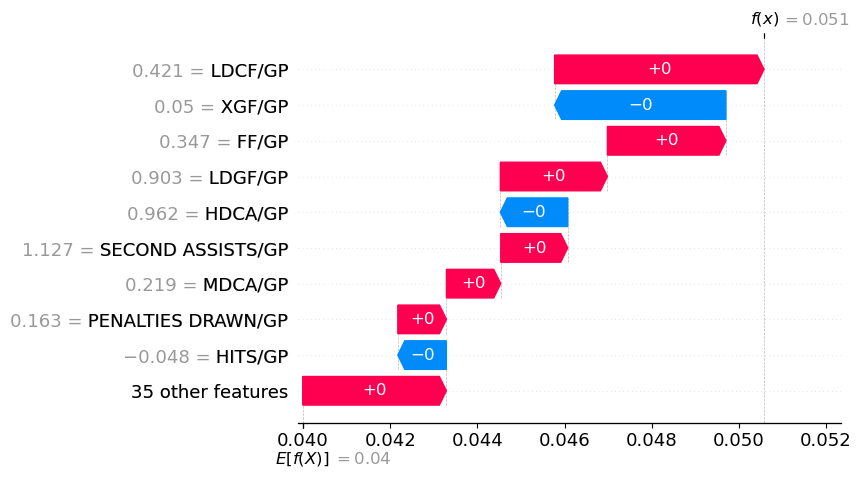

In [33]:
fig = plt.figure()
shap.plots.waterfall(shap_values[0], show=False)
plt.gcf().set_size_inches(7,5)
plt.show()

Feature: XGF/GP, Importance: 0.25838881731033325
Feature: FF/GP, Importance: 0.24629910290241241
Feature: LDCF/GP, Importance: 0.036449480801820755
Feature: SCF/GP, Importance: 0.03547152131795883
Feature: SHOTS/GP, Importance: 0.02735741436481476
Feature: SF/GP, Importance: 0.025600308552384377
Feature: FA/GP, Importance: 0.022288853302598
Feature: ICF/GP, Importance: 0.018903350457549095
Feature: LDCA/GP, Importance: 0.014659810811281204
Feature: LDGF/GP, Importance: 0.014543653465807438
Feature: FIRST ASSISTS/GP, Importance: 0.012916472740471363
Feature: SA/GP, Importance: 0.012780866585671902
Feature: FACEOFFS WON/GP, Importance: 0.011975537985563278
Feature: IFF/GP, Importance: 0.011816662736237049
Feature: HITS TAKEN/GP, Importance: 0.01155041716992855
Feature: MDCA/GP, Importance: 0.010873807594180107
Feature: HDCF/GP, Importance: 0.010790996253490448
Feature: HDCA/GP, Importance: 0.010340365581214428
Feature: CA/GP, Importance: 0.010304353199899197
Feature: MDGF/GP, Importance:

<Figure size 640x480 with 0 Axes>

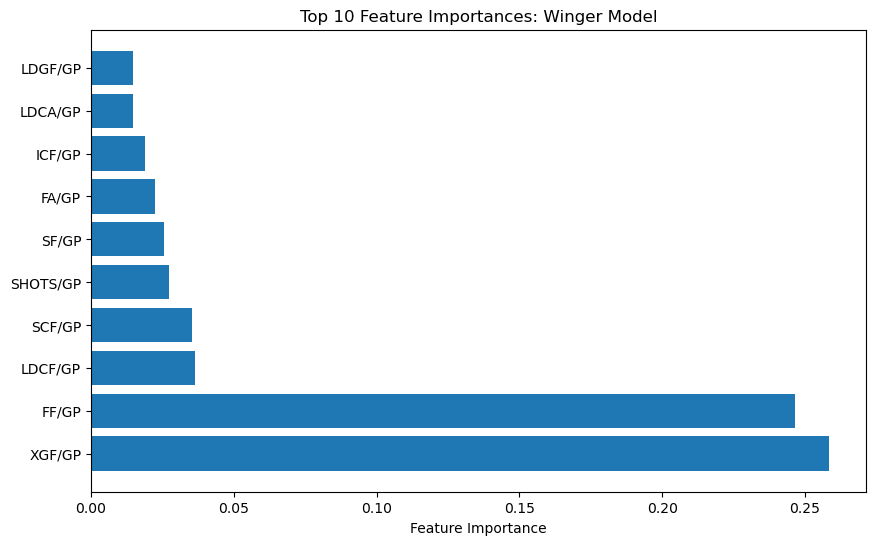

In [38]:
# Access the trained XGBRegressor model from the pipeline
xgb_model = pipeline.named_steps['regressor']

# Retrieve the feature importances
feature_importances = xgb_model.feature_importances_

# Assuming 'numerical_features' holds the original names of the features prior to fitting
# and we are also taking into account that some features might have been dropped by the RFECV step
selected_features = numerical_features[rfecv.support_]

# Combine feature names and their importance scores in a dictionary
feature_importance_dict = dict(zip(selected_features, feature_importances))

# Sort the dictionary by importance scores in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Print sorted feature importances
for feature, importance in sorted_feature_importances:
    print(f"Feature: {feature}, Importance: {importance}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh([feature for feature, _ in sorted_feature_importances][:10], [importance for _, importance in sorted_feature_importances][:10])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances: Winger Model')
plt.show()

In [35]:
shap.plots.force(shap_values[0])

In [36]:
shap.plots.force(shap_values[:100])

In [37]:
fig = plt.figure()
shap.plots.scatter(shap_values[:, "TOI/GP"], color=shap_values, show=False)
plt.gcf().set_size_inches(5,4)
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

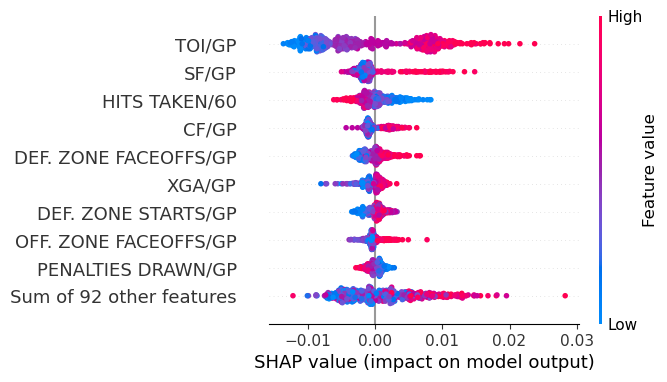

In [ ]:
fig = plt.figure()
shap.plots.beeswarm(shap_values, show=False)
plt.gcf().set_size_inches(5,4)
plt.show()

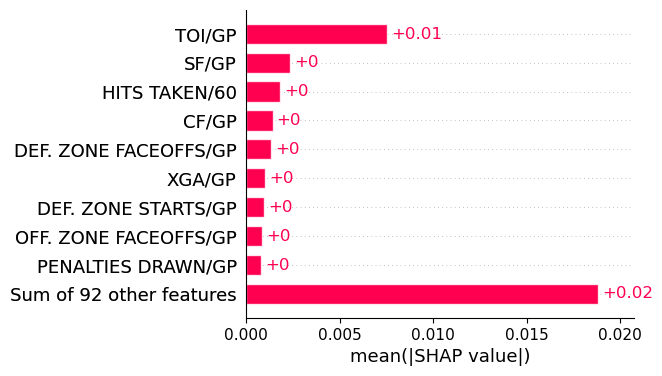

In [ ]:
fig = plt.figure()
shap.plots.bar(shap_values, show=False)
plt.gcf().set_size_inches(5,4)
plt.show()